# Projet MonGueuleTon

Nous allons dans ce notebook entraîner un classifieur d'image de nourriture, avec la base de donnée *Food-101*.   

Cette base de donnée est composée de 101 catégories d'images, chacune composés de 1000 images.

## Imports

In [2]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json


In [3]:
import fastai

fastai.__version__

'2.1.4'

In [4]:
from fastai import *
from fastai.vision import *
from fastai.imports import *
from fastai.vision.all import *


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Extraction des données


In [7]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzf food-101.tar.gz

--2020-12-14 17:22:34--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-12-14 17:22:40--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4,7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4,65G  12,5MB/s    in 8m 7s   

2020-12-14 17:30:47 (9,78 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



## Chargement des données

Chacune des 101 catégories ou classes sont stockés dans un dossier

In [8]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


- Les 5 premières catégories

In [9]:
!ls food-101/images | head -n 5

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare


Chemin vers les images 

In [10]:
path = Path('food-101/images')

Création d'une instance de la classe ImageDataLoaders  et en appliquant des transformations sur chaque image

In [11]:
data = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2, 
    item_tfms=RandomResizedCrop(224),
    num_workers=8,
    bs=64,
    batch_tfms=Normalize.from_stats(*imagenet_stats)
)

In [15]:
data.c, len(data.train_ds), len(data.valid_ds)

(101, 80800, 20200)

# Entrainement du modèle

## Initialisation du Learning Rate

In [15]:
import torchvision.models as models

In [16]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate,pretrained=True)
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=True)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.013182567432522774)

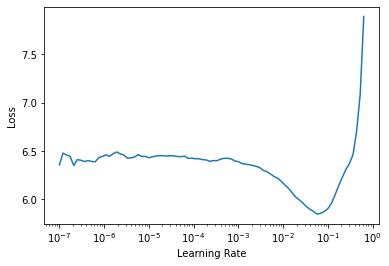

In [10]:
learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [15]:
lr = 0.015

In [16]:
learn.fit_one_cycle(8 , lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.559440,2.140593,0.549406,03:05
1,2.552496,2.083103,0.535347,03:06
2,2.316155,1.790478,0.465446,03:07
3,2.175485,1.615735,0.420099,03:15
4,1.994075,1.392277,0.367475,03:14
5,1.774603,1.270176,0.335842,03:15
6,1.670123,1.192361,0.317871,03:13
7,1.630351,1.170672,0.312574,03:13


### Sauvegarde du modèle

In [17]:
model_name="resnet34-v2"

In [18]:
learn.save(f'{model_name}-stage-1')

Path('data/food-101/images/models/resnet34-v2-stage-1.pth')

## Entrainement des dernières couches
Commme nous utilisons une architecture Resnet34 pré-entrainé, nous allons faire du "Transfer Learning", et uniquement ré-entrainer les dernière couches afin de les spécialiser. 

In [19]:
learn.load(f'{model_name}-stage-1')

In [20]:
learn.unfreeze()


SuggestedLRs(lr_min=7.244359778724174e-09, lr_steep=1.047128517228657e-08)

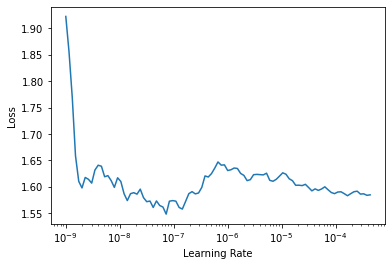

In [21]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)

In [22]:
learn.fit_one_cycle(8, max_lr=slice(1e-8,1e-7))

epoch,train_loss,valid_loss,error_rate,time
0,2.198256,2.530545,0.604208,04:25
1,2.218120,2.220551,0.557178,04:27
2,1.917630,1.838132,0.471881,04:27
3,1.737006,1.355446,0.352376,04:28
4,1.595484,1.162130,0.311881,04:28
5,1.370663,1.004799,0.273218,04:27
6,1.235788,0.928767,0.250594,04:28
7,1.149756,0.910969,0.246980,04:28


In [23]:
learn.save(f'{model_name}-stage-2')

Path('data/food-101/images/models/resnet34-v2-stage-2.pth')

## Interpretation

In [18]:
learn.load(f'{model_name}-stage-2');


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

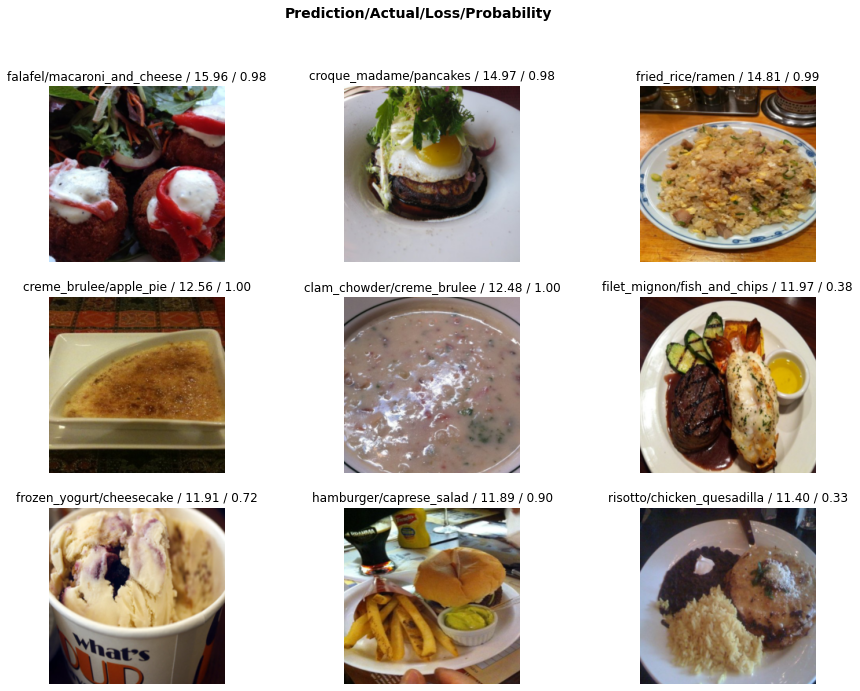

In [20]:
interp.plot_top_losses(9, figsize=(15,11))


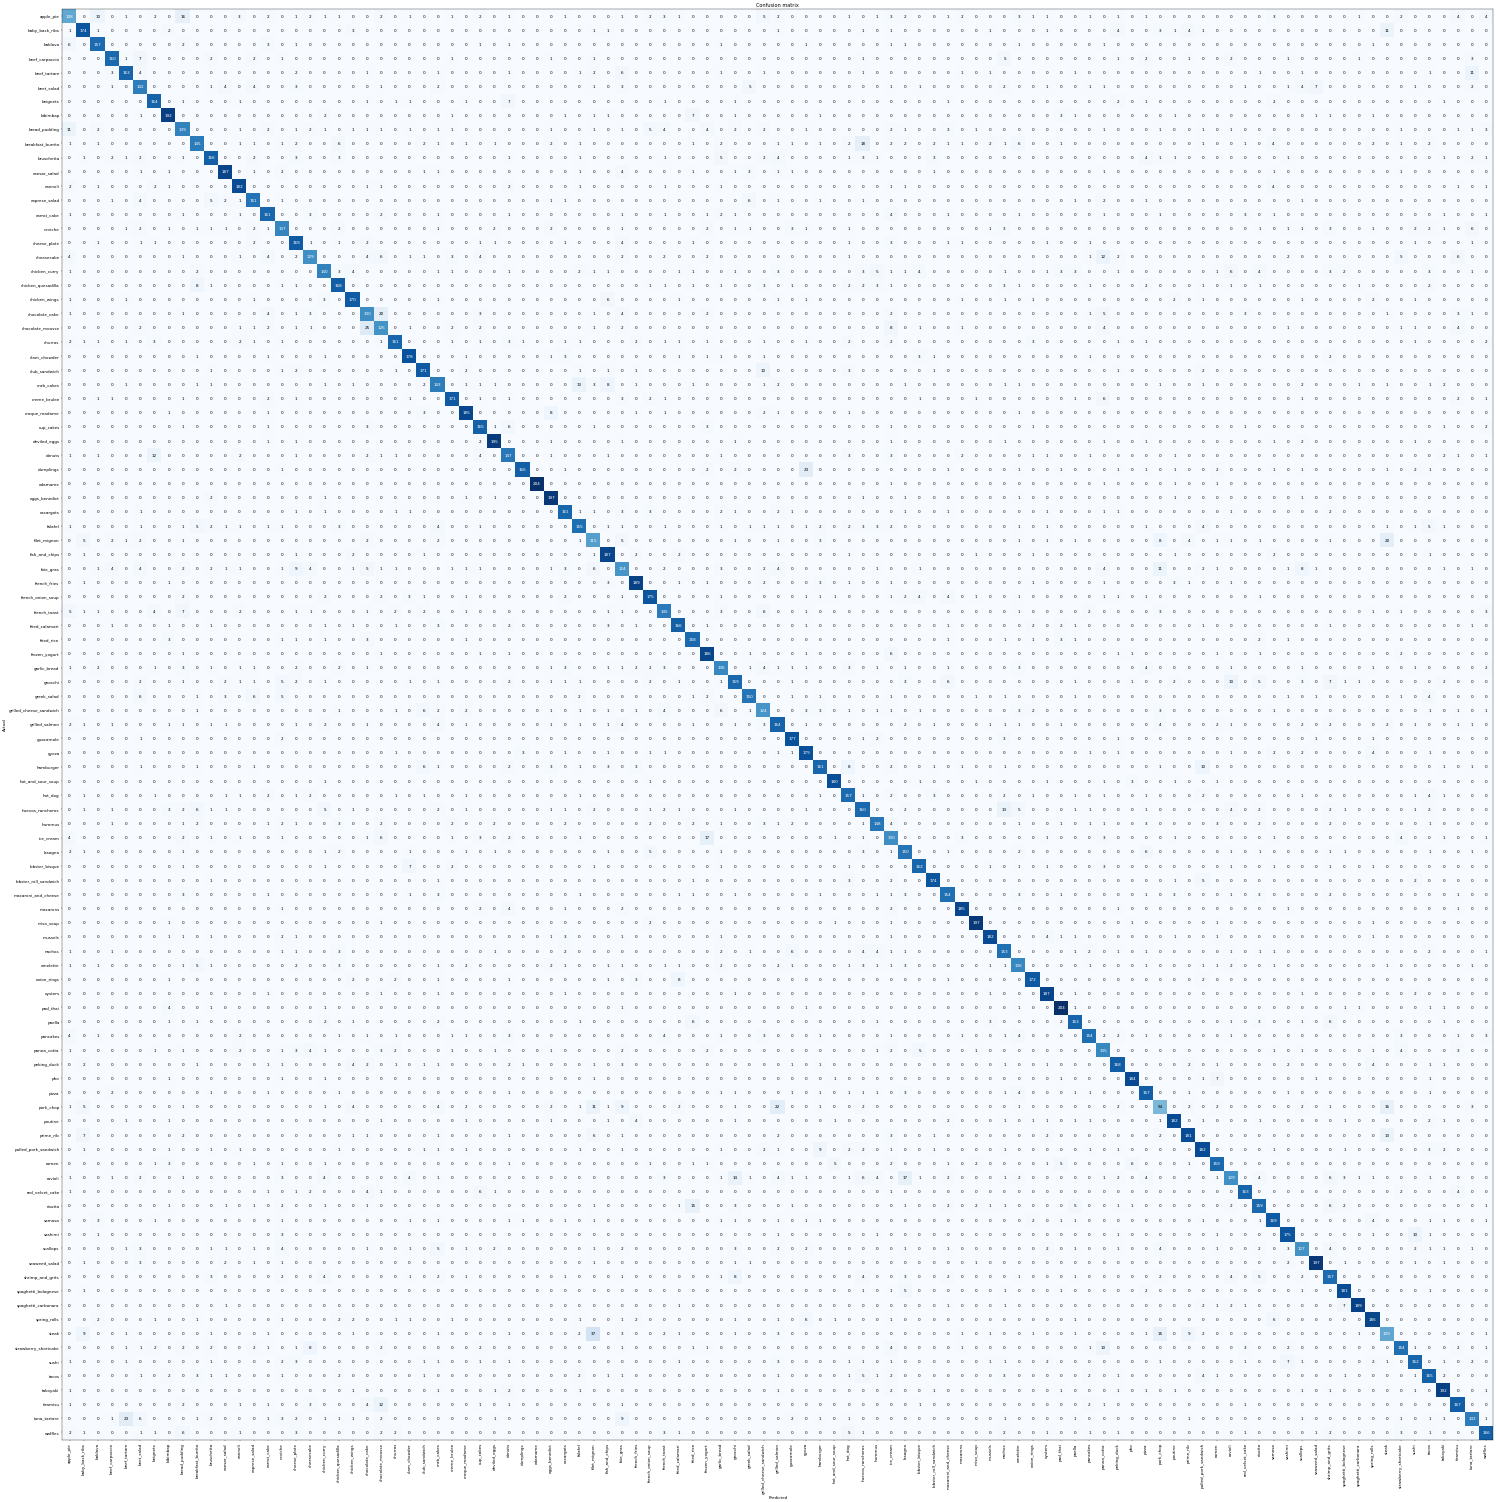

In [21]:
interp.plot_confusion_matrix(figsize=(50,50), dpi=30)


In [24]:
interp.most_confused(min_val=10)


[('steak', 'filet_mignon', 37),
 ('chocolate_mousse', 'chocolate_cake', 25),
 ('dumplings', 'gyoza', 23),
 ('tuna_tartare', 'beef_tartare', 23),
 ('pork_chop', 'grilled_salmon', 22),
 ('chocolate_cake', 'chocolate_mousse', 20),
 ('filet_mignon', 'steak', 20),
 ('breakfast_burrito', 'huevos_rancheros', 18),
 ('ice_cream', 'frozen_yogurt', 17),
 ('ravioli', 'lasagna', 17),
 ('apple_pie', 'bread_pudding', 16),
 ('pork_chop', 'steak', 16),
 ('risotto', 'fried_rice', 15),
 ('steak', 'pork_chop', 15),
 ('ravioli', 'gnocchi', 14),
 ('crab_cakes', 'falafel', 13),
 ('huevos_rancheros', 'nachos', 13),
 ('prime_rib', 'steak', 13),
 ('cheesecake', 'panna_cotta', 12),
 ('donuts', 'beignets', 12),
 ('tiramisu', 'chocolate_mousse', 12),
 ('baby_back_ribs', 'steak', 11),
 ('beef_tartare', 'tuna_tartare', 11),
 ('bread_pudding', 'apple_pie', 11),
 ('foie_gras', 'pork_chop', 11),
 ('pork_chop', 'filet_mignon', 11),
 ('apple_pie', 'baklava', 10),
 ('club_sandwich', 'grilled_cheese_sandwich', 10),
 ('gnoc

### Sauvegarde

In [88]:
final_model_name = f'{model_name}-final'

In [89]:
learn.save(final_model_name)

Path('data/food-101/images/models/resnet34-final.pth')

# Test du modèle

### Chargement du modèle entrainé

In [16]:
from fastai.data.external import *

In [17]:
classif = load_learner("../model.pkl")

In [18]:
pred, pred_idx, raw_outputs = classif.predict("../tests/guacamole.jpg")

In [19]:
pred, pred_idx

('guacamole', TensorImage(51))

In [23]:
print(raw_outputs)
print(sum(raw_outputs))

TensorImage([1.1186e-07, 2.2247e-07, 3.4756e-07, 1.0711e-07, 2.5574e-06, 2.7363e-07,
        4.3621e-09, 8.2816e-07, 1.4904e-08, 5.6574e-05, 1.6328e-07, 1.0135e-04,
        4.5559e-07, 7.0894e-08, 1.1950e-08, 2.6090e-05, 6.5865e-08, 5.7056e-09,
        5.8464e-06, 8.7328e-05, 4.8660e-08, 7.9409e-09, 2.5101e-08, 7.8243e-10,
        1.2160e-07, 6.6377e-07, 2.0272e-07, 3.3037e-08, 2.0881e-08, 1.5291e-08,
        2.0949e-07, 1.4368e-08, 4.8744e-07, 1.5835e-07, 1.0989e-08, 1.5887e-06,
        2.0574e-04, 9.6233e-08, 2.1612e-06, 7.2308e-09, 8.9533e-08, 1.8646e-08,
        2.6184e-08, 9.7132e-09, 4.1901e-06, 2.7266e-07, 1.8379e-06, 1.8963e-07,
        1.2186e-05, 6.6275e-07, 6.9388e-07, 9.9836e-01, 7.9450e-08, 2.7546e-06,
        2.3181e-08, 1.0025e-05, 7.2715e-05, 1.9192e-04, 9.2920e-07, 9.2077e-07,
        3.4509e-08, 2.9473e-06, 1.5652e-06, 9.3816e-09, 6.7980e-08, 8.1939e-08,
        2.8056e-04, 4.3531e-04, 1.3217e-08, 2.1241e-09, 4.4979e-08, 4.0719e-06,
        2.0002e-07, 3.2845e-09, 1.5